In diesem Notebook transformieren wir die Spektrogramme mittels PCA in einen niederdimensionalen Raum (1,2,3,5,10,100 Dimensionen). Zuerst werden die Daten in 2 und 3 Dimensionen visualisiert. Anschließend wenden wir verschiedene Verfahren auf die Daten in den Kompressionsräumen an.

In [91]:
# Die Daten befinden sich in der Datenbank. read_data stellt eine Funktion read_data bereit, die die Anzahl der Spektrogramme pro Klasse erhält
# und die Daten aus der Datenbank einliest, sklaliert, die STFT durchführt und das Ganze in einen pandas.DataFrame data schreibt. Wichtig sind
# hierbei die Spalten data['arr'], die tatsächlichen Daten und data['target'], die Klassenzugehörigkeit.

import read_data
data = read_data.read_data(300)
print(data.head(5))

/home/lo/pg/ML/ML-Projekt/read_data.py:30: RuntimeWarning:

divide by zero encountered in log10



    call  target  id             bat  \
0  38818       0   0  Bartfledermaus   
1  46731       0   1  Bartfledermaus   
2  49137       0   2  Bartfledermaus   
3  49557       0   3  Bartfledermaus   
4  22197       0   4  Bartfledermaus   

                                                 arr     db  
0  [[[0.5383580417881516], [0.5394855702323632], ...  skiba  
1  [[[0.570258907583444], [0.5589728547063831], [...  skiba  
2  [[[0.5736033747601932], [0.5694056445135038], ...  skiba  
3  [[[0.5302138933564621], [0.5282555104293256], ...  skiba  
4  [[[0.6601127852592856], [0.6601250353256682], ...  skiba  


In [92]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [93]:
# Die Daten und Targets werden in numpy.Arrays mit den richtigen Shapes geschrieben 

X = np.concatenate(data['arr'].values).reshape(-1, 256*128)
print(X.shape)

y = data['target']
print(y.shape)

(5700, 32768)
(5700,)


Dimensionsreduktion mit PCA und der Anteil der erklärten Varianz für einige Dimensionen

In [94]:
dims = [1, 2, 3, 5, 10, 100]
X_pca = []

for dim in dims:
    pca = PCA(n_components=dim)
    transformed = pca.fit_transform(X)
    X_pca.append(transformed)
    print(f"{dim} Hauptkomponente(n): {sum(pca.explained_variance_ratio_):.3f} variance explained")

1 Hauptkomponente(n): 0.575 variance explained
2 Hauptkomponente(n): 0.651 variance explained
3 Hauptkomponente(n): 0.699 variance explained
5 Hauptkomponente(n): 0.753 variance explained
10 Hauptkomponente(n): 0.800 variance explained
100 Hauptkomponente(n): 0.881 variance explained


Visualierung der transformierten Daten (2, 3 Dimensionen)

/tmp/ipykernel_2785/4249318831.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/tmp/ipykernel_2785/4249318831.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_map = plt.cm.get_cmap('jet', 19)


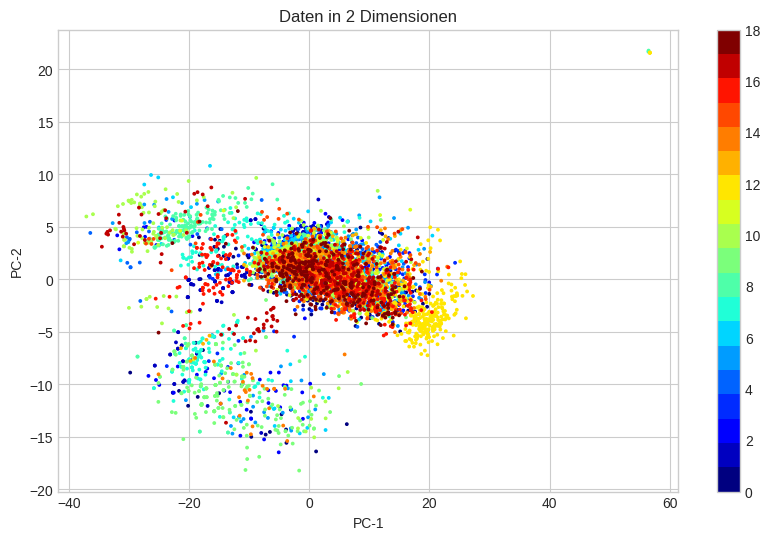

In [10]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 19)
plt.scatter(X_pca[1][:, 0], X_pca[1][:, 1], s = 3,
            cmap = c_map , c = y)
plt.colorbar()
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.title('Daten in 2 Dimensionen')
plt.show()

Die Daten in 2 Dimensionen sehen nicht vielversprechend aus. Einige Cluster sind teilweise erkennbar. Die große Überschneidung ist sehr schlecht für die (lineare) Trennbarkeit der Daten. Prognose: Ergebnisse werden nicht gut sein

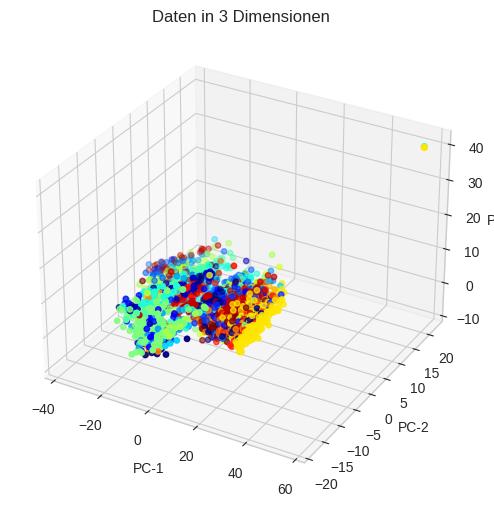

In [11]:
# Statischer Plot

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(X_pca[2][:, 0], X_pca[2][:, 1], X_pca[2][:, 2], s = 15,
            cmap = c_map , c = y)

ax.set_xlabel('PC-1')
ax.set_ylabel('PC-2')
ax.set_zlabel('PC-3')
ax.set_title('Daten in 3 Dimensionen')

plt.show()

Gleiches gilt für den 3-dimensionalen Kompressionsraum. Separierbarkeit ist schwierig. Vermutung: Ebensfalls schlechte Ergebnisse

In [12]:
# KNN mit k zwischen 1 und 100 auf den transformierten Daten. LLOCV wäre gut, da deterministische Ergebnisse, dauert aber zu lange, deshalb CV 
# mit 5 Splits. Als Ergebnis wird der Durchschnitt der jeweiligen Accuracies verwendet

k = range(1, 101)
scores_knn = []

for i, pca_data in enumerate(X_pca):
    scores_knn.append([])
    for n_neighbors in k:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        scores = cross_validate(knn, pca_data, y)
        scores_knn[i].append(np.mean(scores["test_score"]))

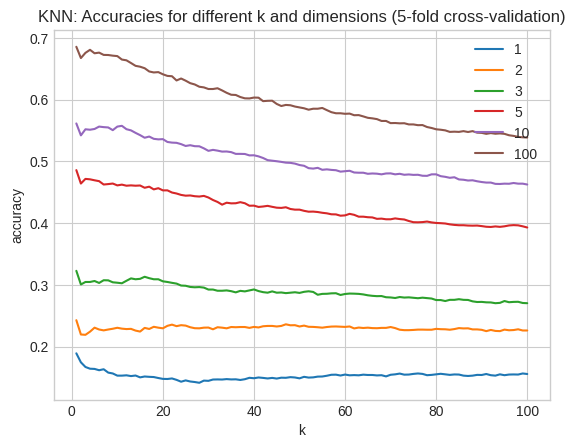

In [19]:
# Visualisierung der Ergebnisse

for elem in scores_knn:
    plt.plot(k, elem, label=dims[scores_knn.index(elem)])
plt.xlabel("k")
plt.ylabel("accuracy")
plt.legend(loc="upper right")
plt.title("KNN: Accuracies for different k and dimensions (5-fold cross-validation)")
plt.show()

Ergebnis von KNN: Mit vielen Dimensionen noch ordentliche Ergebnisse aber im niedrig-dimensionalen Raum nicht mehr praktikabel. Ein kleines k ist tendenziell besser als sehr große k.

In [20]:
# KLassifikation mit Decision Trees. Für jeden der Kompressionsräume wird getestet, welchen Einfluss die maximale Tiefe und das criterion für die
# Accuracy hat

from sklearn.tree import DecisionTreeClassifier

max_depths = range(1, 11)
criterions_tree = ["gini", "entropy", "log_loss"]

scores_tree = []

for i, pca_data in enumerate(X_pca):
    scores_tree.append([])
    for j, criterion in enumerate(criterions_tree):
        scores_tree[i].append([])
        for max_depth in max_depths:
            tree = DecisionTreeClassifier(criterion=criterion,
                                        max_depth=max_depth)
            scores = cross_validate(tree, pca_data, y)
            scores_tree[i][j].append(np.mean(scores["test_score"]))

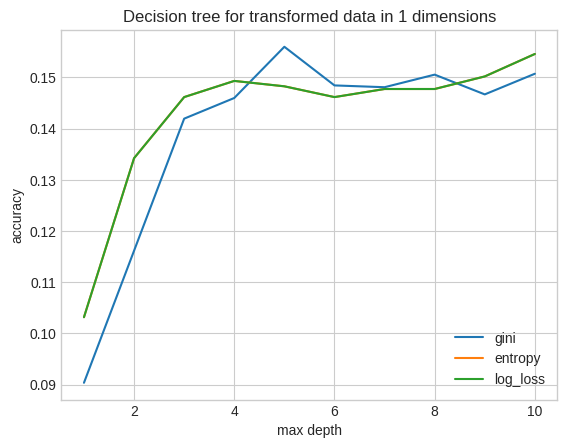

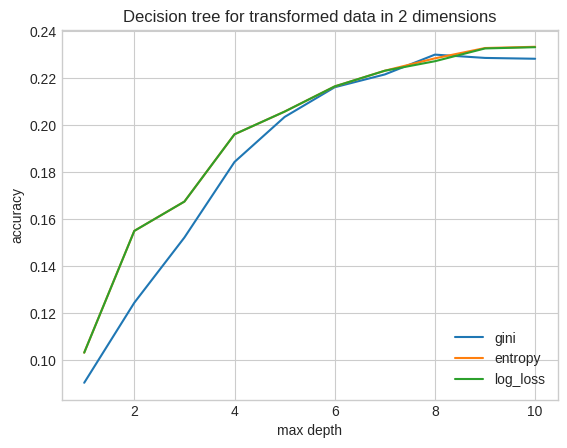

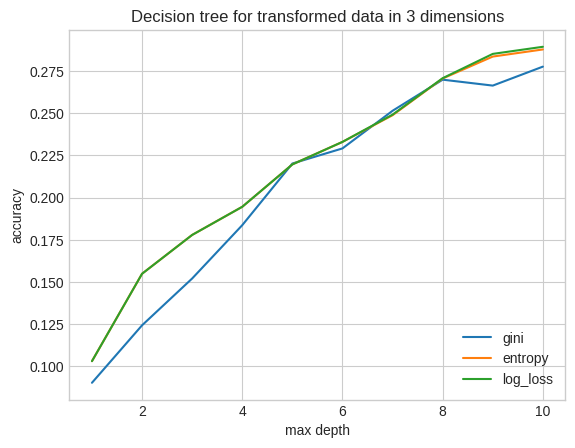

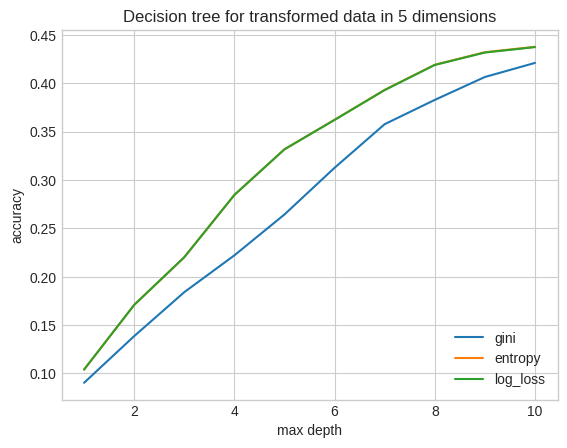

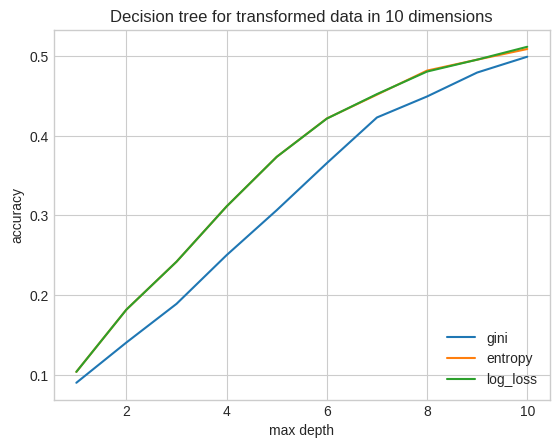

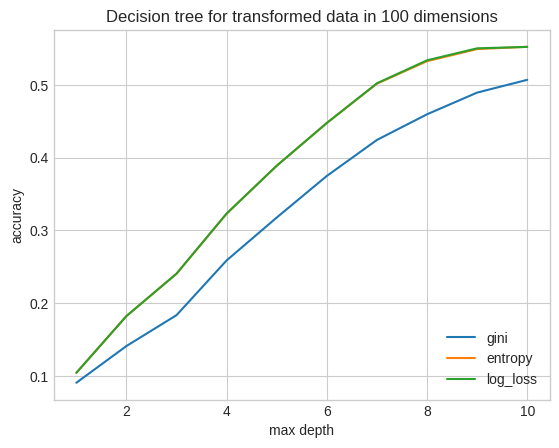

In [33]:
# Visualisierung der Ergebnisse. Für jeden Kompressionsraum ein eigener Graph

for elem in scores_tree: 
    for i, criterion in enumerate(elem):
        plt.plot(max_depths, elem[i], label=criterions_tree[i])
    plt.xlabel("max depth")
    plt.ylabel("accuracy")
    plt.title(f"Decision tree for transformed data in {dims[scores_tree.index(elem)]} dimensions")
    plt.legend(loc="lower right")
    plt.show()

Die Ergebnisse sind für wenige Dimensionen erwartbar schlecht. Die Prognose bestätigt sich.

Jetzt verschiedene Ensemble-Verfahren:
1. Random Forest
2. Bagging
3. Extra Random
4. AdaBoost
5. Gradient Boosting

In [34]:
from sklearn.ensemble import RandomForestClassifier

n_estimators_rf = range(50, 250, 50)
criterions_rf = ["gini"] # , "entropy", "log_loss"] dauert sonst zu lange

scores_rf = []

for i, pca_data in enumerate(X_pca[:3]): # dauert sonst zu lange
    scores_rf.append([])
    for j, criterion in enumerate(criterions_rf):
        scores_rf[i].append([])
        for n_estimator in n_estimators_rf:
            rf = RandomForestClassifier(criterion=criterion,
                                        n_estimators=n_estimator)
            scores = cross_validate(rf, pca_data, y)
            scores_rf[i][j].append(np.mean(scores["test_score"]))

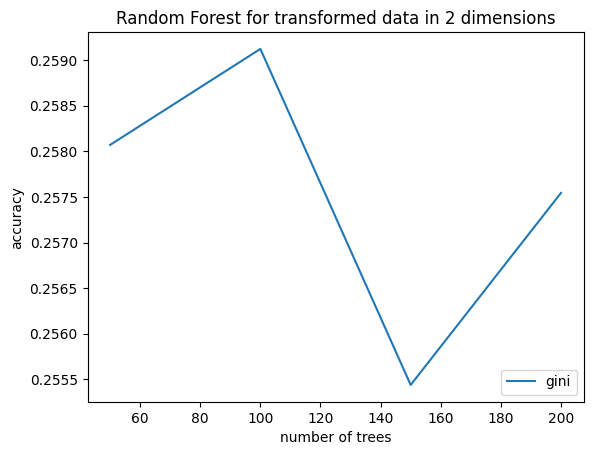

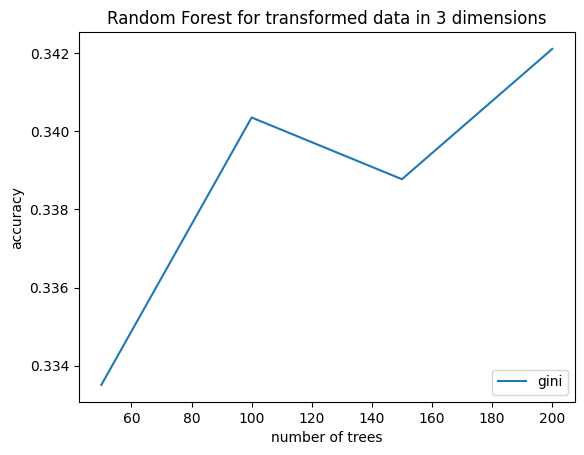

In [23]:
# Hiermit könnte man die Ergebnisse für alle Accuracies plotten

for elem in scores_rf: 
    for i, criterion in enumerate(elem):
        plt.plot(n_estimators_rf, elem[i], label=criterions_rf[i])
    plt.xlabel("number of trees")
    plt.ylabel("accuracy")
    plt.title(f"Random Forest for transformed data in {dims[scores_rf.index(elem)]} dimensions")
    plt.legend(loc="lower right")
    plt.show()

Random Forest liefert für die entscheidenden Dimensionen schlechte Ergebnisse

In [97]:
from sklearn.ensemble import BaggingClassifier

n_estimators_bagging = range(10, 110, 10)

scores_bagging = []

for i, pca_data in enumerate(X_pca):
    scores_bagging.append([])
    for n_estimator in n_estimators_bagging:
        bagging = BaggingClassifier(n_estimators=n_estimator)
        scores = cross_validate(bagging, pca_data, y)
        scores_bagging[i].append(np.mean(scores["test_score"]))

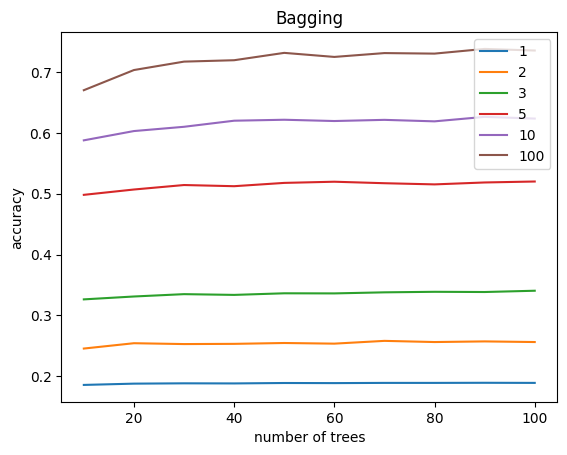

In [25]:
for i, elem in enumerate(scores_bagging):
    plt.plot(n_estimators_bagging, elem, label=dims[i])
plt.xlabel("number of trees")
plt.ylabel("accuracy")
plt.title("Bagging")
plt.legend(loc="upper right")
plt.show()

Auch Bagging liefert nur mit vielen Dimensionen ordentliche Ergebnisse.

In [30]:
from sklearn.ensemble import ExtraTreesClassifier

n_estimators_et = range(20, 220, 20)
criterions_et = ["gini"] # , "entropy", "log_loss"] dauert sonst zu lange

scores_et = []

for i, pca_data in enumerate(X_pca[:3]):
    scores_et.append([])
    for j, criterion in enumerate(criterions_et):
        scores_et[i].append([])
        for n_estimator in n_estimators_et:
            et = ExtraTreesClassifier(criterion=criterion,
                                    n_estimators=n_estimator)
            scores = cross_validate(et, pca_data, y)
            scores_et[i][j].append(np.mean(scores["test_score"]))

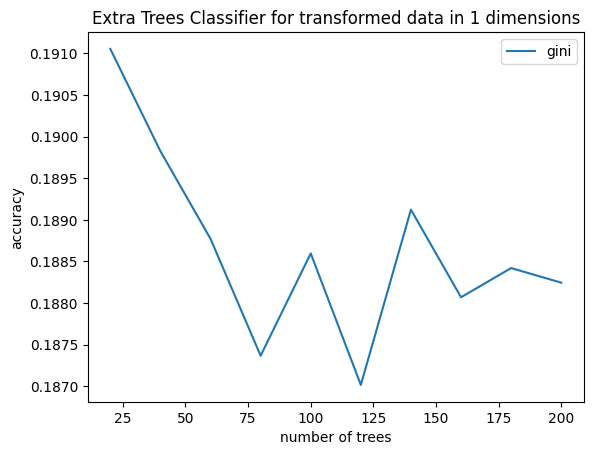

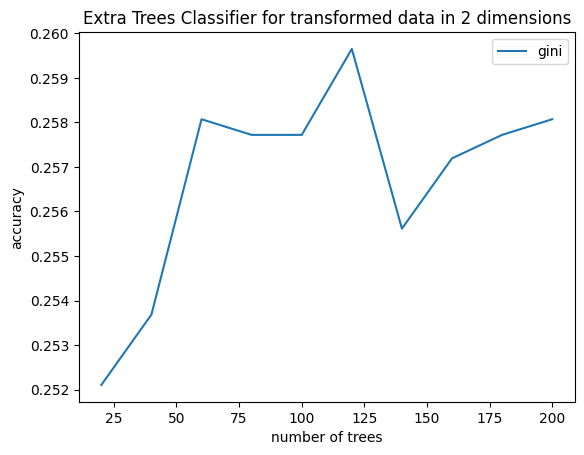

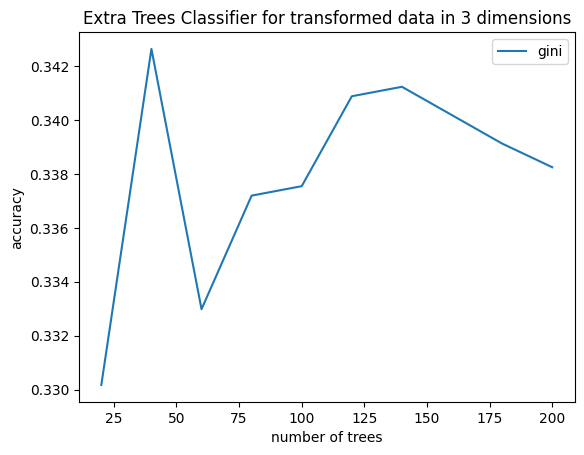

In [31]:
for elem in scores_et: 
    for i, criterion in enumerate(elem):
        plt.plot(n_estimators_et, elem[i], label=criterions_et[i])
    plt.xlabel("number of trees")
    plt.ylabel("accuracy")
    plt.title(f"Extra Trees Classifier for transformed data in {dims[scores_et.index(elem)]} dimensions")
    plt.legend(loc="upper right")
    plt.show()

Auch der Extra Tree Classifier liefert enttäuschende Ergebnisse.

In [6]:
from sklearn.ensemble import AdaBoostClassifier

n_estimators_ada = range(20, 220, 20)
learning_rates = np.arange(0.2, 2.2, 0.2)

scores_ada = []

for i, pca_data in enumerate(X_pca[:3]):
    scores_ada.append([])
    for j, lr in enumerate(learning_rates):
        scores_ada[i].append([])
        for n_estimator in n_estimators_ada:
            ada = AdaBoostClassifier(learning_rate=lr,
                                    n_estimators=n_estimator)
            scores = cross_validate(ada, pca_data, y)
            scores_ada[i][j].append(np.mean(scores["test_score"]))

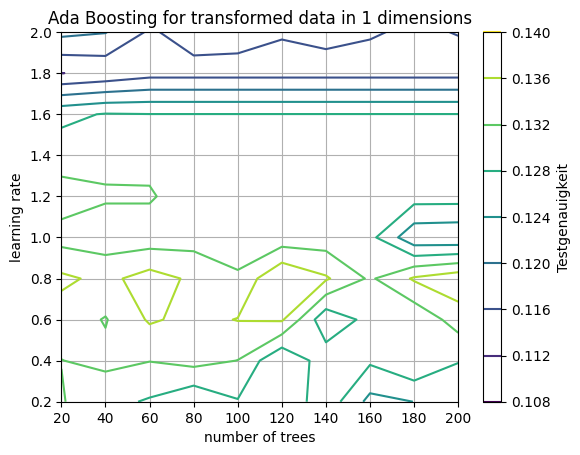

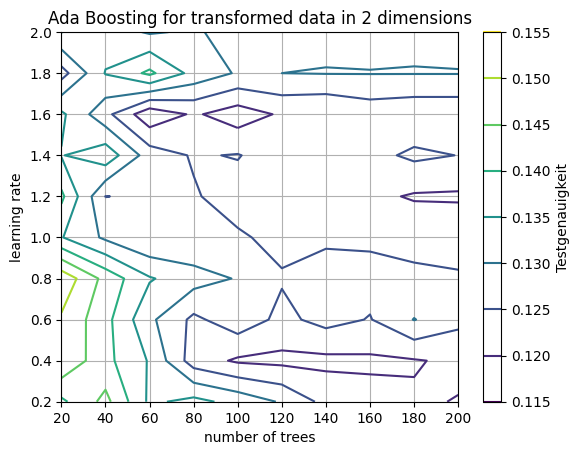

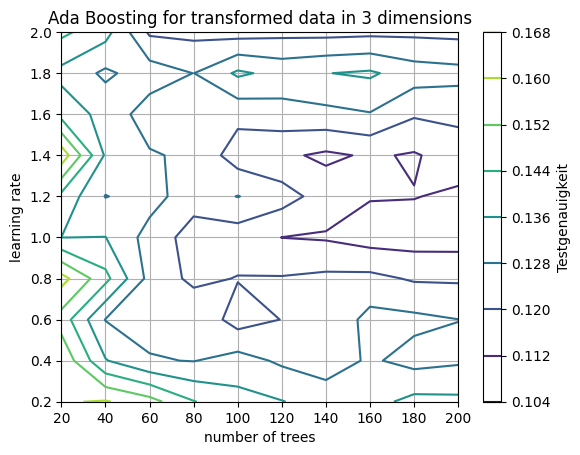

In [11]:
for elem in scores_ada:
    C = plt.contour(n_estimators_ada, learning_rates, np.array(elem).reshape(10, 10), cmap='viridis')
    plt.colorbar(C, label='Testgenauigkeit')
    plt.xlabel("number of trees")
    plt.ylabel("learning rate")
    plt.title(f"Ada Boosting for transformed data in {dims[scores_ada.index(elem)]} dimensions")
    plt.xticks(n_estimators_ada)
    plt.yticks(learning_rates)
    plt.grid(visible=True)
    plt.show()

Mit AdaBoost sind die Ergebnisse noch schlechter. Nicht einmal 15 % werden in der besten Konfiguration erreicht.

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators_gb = range(50, 200, 50) # dauert sonst zu lange

scores_gb = []

for i, pca_data in enumerate(X_pca[2:3]):
    scores_gb.append([])
    for n_estimator in n_estimators_gb:
        gb = GradientBoostingClassifier(n_estimators=n_estimator)
        scores = cross_validate(gb, pca_data, y)
        scores_gb[i].append(np.mean(scores["test_score"]))

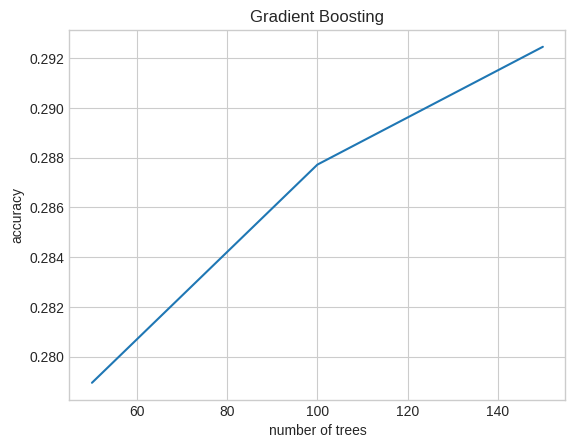

In [39]:
for i, elem in enumerate(scores_gb):
    plt.plot(n_estimators_gb, elem, label=dims[i])
plt.xlabel("number of trees")
plt.ylabel("accuracy")
plt.title("Gradient Boosting")
plt.show()

Auch Decision Trees und die Ensemble Verfahren liefern schlechte Ergebnisse.

Letzte Hoffnung: Versuch im Kompressionsraum FFNN anzuwenden

In [40]:
from tensorflow import keras
from keras.layers import Dense

In [41]:
# Aufteilen der jeweiligen Daten Trainings- und Testdaten

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X_trains = []
X_tests = []
y_trains = []
y_tests = []

y_categorical = to_categorical(y)

for i in range(len(dims)):
    X_train, X_test, y_train, y_test = train_test_split(X_pca[i], y_categorical, test_size=0.2)
    X_trains.append(X_train)
    X_tests.append(X_test)
    y_trains.append(y_train)
    y_tests.append(y_test)

In [51]:
# Verwenden der PlotLosses Klasse aus Practice 10 (um die Accuracies erweitert)

from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('categorical_accuracy'))
        self.val_accuracy.append(logs.get('val_categorical_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.plot(self.x, self.accuracy, label="accuracy")
        plt.plot(self.x, self.val_accuracy, label="val_accuracy")
        plt.legend()
        plt.show()
        
plot_losses = PlotLosses()

In [52]:
# Funktion um ein einfaches Netz zu erstellen, das dann kompiliert und trainiert wird

def build_model(i):
    model = keras.Sequential()

    model.add(Dense(64, activation="relu", input_shape=(dims[i],)))
    model.add(Dense(64, activation="relu")),
    model.add(Dense(19, activation="softmax")),

    # Modell kompilieren
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=[keras.metrics.CategoricalAccuracy()])

    # Modell trainieren
    model.fit(X_trains[i], y_trains[i],
              validation_data=(X_tests[i], y_tests[i]), 
              epochs=100,
              batch_size=32,
              verbose=1,
              callbacks=[plot_losses])

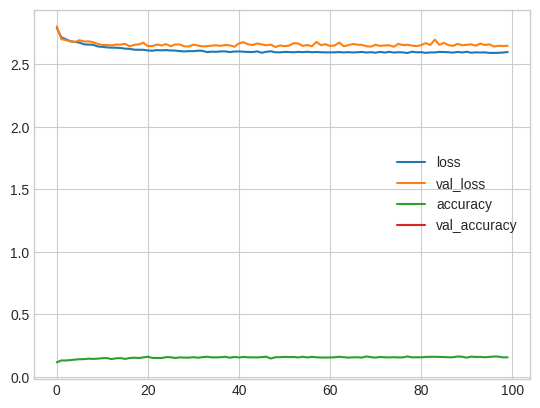

143/143 [==============================] - 0s 3ms/step - loss: 2.5989 - categorical_accuracy: 0.1566 - val_loss: 2.6482 - val_categorical_accuracy: 0.1518


In [47]:
# NN auf Kompressionsraum mit 1 Dimension

build_model(0)

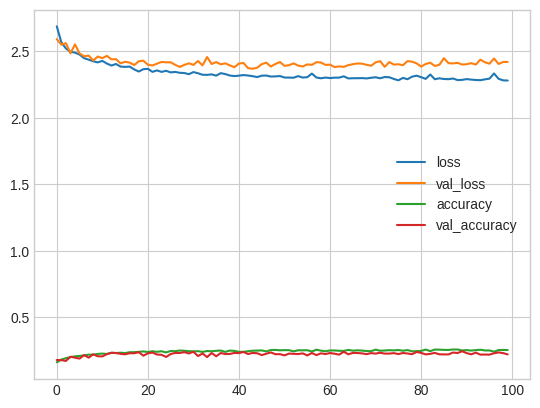

143/143 [==============================] - 0s 3ms/step - loss: 2.2809 - categorical_accuracy: 0.2539 - val_loss: 2.4210 - val_categorical_accuracy: 0.2211


In [53]:
# NN auf Kompressionsraum mit 2 Dimension

build_model(1)

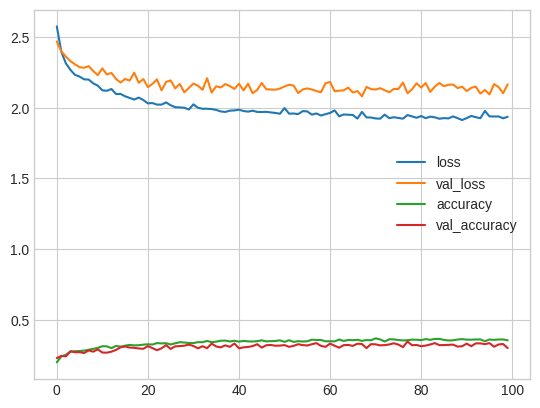

143/143 [==============================] - 0s 3ms/step - loss: 1.9354 - categorical_accuracy: 0.3539 - val_loss: 2.1651 - val_categorical_accuracy: 0.2991


In [54]:
# NN auf Kompressionsraum mit 3 Dimension

build_model(2)

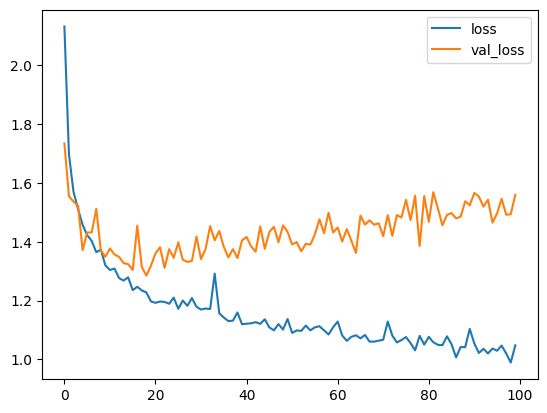

143/143 [==============================] - 0s 3ms/step - loss: 1.0478 - categorical_accuracy: 0.6248 - val_loss: 1.5591 - val_categorical_accuracy: 0.5526


In [60]:
# NN auf Kompressionsraum mit 5 Dimension

build_model(3)

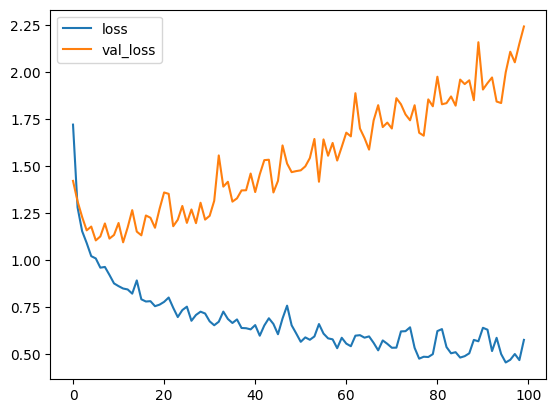

143/143 [==============================] - 0s 3ms/step - loss: 0.5747 - categorical_accuracy: 0.8024 - val_loss: 2.2441 - val_categorical_accuracy: 0.6377


In [61]:
# NN auf Kompressionsraum mit 10 Dimension

build_model(4)

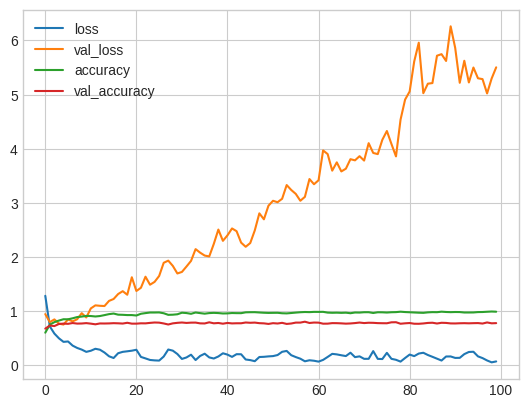

143/143 [==============================] - 1s 5ms/step - loss: 0.0683 - categorical_accuracy: 0.9873 - val_loss: 5.5031 - val_categorical_accuracy: 0.7763


In [55]:
# NN auf Kompressionsraum mit 100 Dimension

build_model(5)

Ergebnis: Auch neuronale Netze erreichen nur schlechte Ergebnisse, wenn die Daten nicht sauber trennbar sind. Erst mit weit über 10 bis 100 Dimensionen kann ein ordentliches Ergebnis erzielt werden. Je mehr Dimesionen verfügbar, desto schneller overfitted das Model. Bei 100 Dimensionen schon nach ca. 5 Epochen maximale Testgenauigkeit erreicht während der Testfehler danach immer größer wird.

Die Ergebnisse sind allgemein für die niederdimensionalen Kompressionsräume sehr schlecht und praktisch nicht einsetzbar. Mit mehr Dimensionen steigt die erklärte Varianz und somit auch die Ergebnisse der Verfahren. Das eigentliche Ziel, eine relativ einfache Klassifikation in visualisierbaren Kompressionsräumen (bis 3 Dimensionen) durchzuführen ist nicht ausführbar.